Diagnoses use ICD9 - can cluster them into the chapters: https://en.wikipedia.org/wiki/List_of_ICD-9_codes

We already have:
- number of medications
- We have discharge dest and if they were admitted as an emergency


Initial thoughts:

- From the data, those with more medical history - more hospital visits, etc., more medications, 
- discharged to home also was less on non-readdmissions - but discharged to home /w some health service etc. was higher - aligns with people with more medical needs not doing welll after they leave hospital
- also those with "change" in medication see higher rates of readmission
- those with diabetes meds see higher rates of readmission

The story is, those with complex health needs, (made easier to get meds wrong if they've changed), are more likely to see readmission

NEED TO LOOK AT CHARLSON
https://github.com/samisaf/Calculating-Charlson-comorbidity-index-based-on-ICD9-codes/blob/master/input/CharlsonRules3.csv


Methods:
- correlation matrix on the inputs
- pairgrid on the inputs
- think about ROC and AUC
    - what is the best threshold? Does this matter for this problem? (probably, as we want to predict if specific patients would be readmitted)
- R2 - what degree of variation in the data do the models explain?
- for the complex model - the SHAP / LIME for explanability

In [1]:
import pandas as pd
import src.utils as utils

recalculate = False

In [2]:
if recalculate:
    file_path = "data/Diabetes.xlsx"

    # Load the Excel file into a pandas dataframe
    df = pd.read_excel(file_path)
    df['age_interval'] = df['age'].apply(utils.interval_type)
    df['age_factor'] = df['age_interval'].apply(utils.charlson_factor_age)
    df['diag_1_factor'] = df['diag_1'].apply(utils.charlson_factor_icd9)
    df['diag_2_factor'] = df['diag_2'].apply(utils.charlson_factor_icd9)
    df['diag_3_factor'] = df['diag_3'].apply(utils.charlson_factor_icd9)
    df['charlson_comorb_index'] = df.apply(lambda x: utils.charlson_comorb_index([x['diag_1'],x['diag_2'],x['diag_3']], x['age_interval']), axis=1)
    df.to_csv("data/Diabetes_Charlson.csv", index=False)
else:	
    df = pd.read_csv("data/Diabetes_Charlson.csv")

In [11]:
df.columns[df.dtypes != 'object']

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'readmitted', 'age_factor',
       'diag_1_factor', 'diag_2_factor', 'diag_3_factor',
       'charlson_comorb_index', 'discharged_home'],
      dtype='object')

In [3]:
features = ['race', 'gender', 'age', 'weights', 'admission_type_id', 'discharged_home', 
            'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 
            'num_medications','number_outpatient', 'number_emergency', 'number_inpatient', 
            'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 
            'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 
            'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
            'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin',
            'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 
            'metformin-pioglitazone', 'change', 'diabetesMed', 'charlson_comorb_index']

df

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,readmitted,diag_1_desc,diag_2_desc,diag_3_desc,age_interval,age_factor,diag_1_factor,diag_2_factor,diag_3_factor,charlson_comorb_index
0,Caucasian,Female,[50-60),?,Elective,Discharged to home,Physician Referral,1,CP,Surgery-Neuro,...,False,Spinal stenosis in cervical region,Spinal stenosis in cervical region,"Effusion of joint, site unspecified","[50, 60)",1,0,0,0,1
1,Caucasian,Female,[20-30),[50-75),Urgent,Discharged to home,Physician Referral,2,UN,?,...,False,"First-degree perineal laceration, unspecified ...","Diabetes mellitus of mother, complicating preg...",Sideroblastic anemia,"[20, 30)",0,0,0,0,0
2,Caucasian,Male,[80-90),?,Not Available,Discharged/transferred to home with home healt...,NaN,7,MC,Family/GeneralPractice,...,True,Pneumococcal pneumonia [Streptococcus pneumoni...,"Congestive heart failure, unspecified",Hyperosmolality and/or hypernatremia,"[80, 90)",4,0,1,0,5
3,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Transfer from another health care facility,4,UN,?,...,False,Cellulitis and abscess of face,Streptococcus infection in conditions classifi...,Diabetes mellitus without mention of complicat...,"[50, 60)",1,0,0,1,2
4,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Emergency Room,5,?,Psychiatry,...,False,"Bipolar I disorder, single manic episode, unsp...",Diabetes mellitus without mention of complicat...,Depressive type psychosis,"[50, 60)",1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Caucasian,Female,[60-70),?,Elective,Discharged/transferred to home with home healt...,Physician Referral,3,MC,?,...,False,"Osteoarthrosis, generalized, site unspecified",Malignant essential hypertension,Pure hypercholesterolemia,"[60, 70)",2,0,0,0,2
9996,AfricanAmerican,Male,[60-70),?,Urgent,Discharged/transferred to SNF,Emergency Room,8,CM,Emergency/Trauma,...,False,"Acute, but ill-defined, cerebrovascular disease",Diabetes mellitus without mention of complicat...,Fitting and adjustment of other device,"[60, 70)",2,1,0,0,3
9997,AfricanAmerican,Female,[70-80),?,Emergency,Discharged/transferred to home with home healt...,Emergency Room,13,?,InternalMedicine,...,True,Streptococcal septicemia,Chronic kidney disease (ckd),Achlorhydria,"[70, 80)",3,0,2,0,5
9998,Caucasian,Male,[80-90),?,Urgent,Discharged/transferred to SNF,Emergency Room,2,MC,InternalMedicine,...,False,"Acute gastritis, without mention of hemorrhage",Hyperosmolality and/or hypernatremia,"Urinary tract infection, site not specified","[80, 90)",4,0,0,0,4


In [4]:
def discharged_home(discharge_disposition: str) -> str:
    """True if the patient was discharged to home, false otherwise"""
    return discharge_disposition == 'Discharged to home'

In [5]:
df['discharged_home'] = discharged_home(df['discharge_disposition_id'])

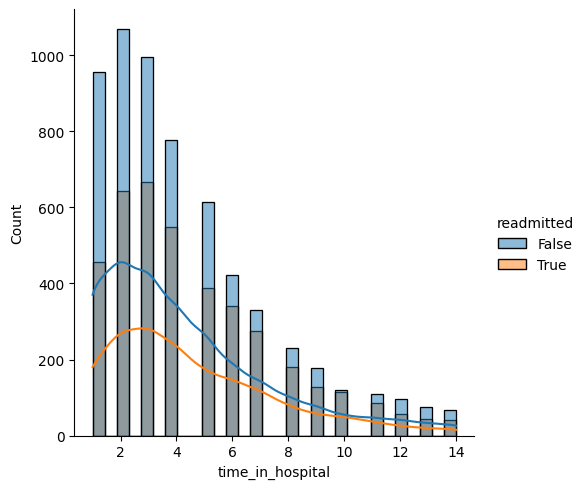

In [6]:
import seaborn as sns

# make histogram of age variable split by readmitted
sns.displot(df, x='time_in_hospital', bins=30, kde=True,hue='readmitted')

In [ ]:
for int64_column in df.columns[df.dtypes == 'int64']:
    #print(int64_column)
    sns.displot(df, x=int64_column,hue='readmitted', stat='proportion', multiple='dodge')
    group_readmitted = df.loc[:,[int64_column,'readmitted']].groupby('readmitted')
    print(group_readmitted.describe())


In [13]:
def group_and_value_count_by_readmitted(df,column):
    """Returns a dataframe with the count of each value in the specified column grouped by readmitted"""
    
    group_readmitted = df.loc[:,[column,'readmitted']].groupby('readmitted')

    return pd.concat([group_readmitted.value_counts(normalize=True),
               group_readmitted.value_counts()
               ],axis=1)

for cat_column in df.drop('readmitted',axis=1).columns:#[df.dtypes == 'object']:
    print(cat_column)
    print(group_and_value_count_by_readmitted(df,cat_column))

    

race
                            proportion  count
readmitted race                              
False      Caucasian          0.711682   4295
           AfricanAmerican    0.222204   1341
           ?                  0.027672    167
           Hispanic           0.019221    116
           Other              0.013256     80
           Asian              0.005965     36
True       Caucasian          0.772762   3064
           AfricanAmerican    0.182093    722
           Hispanic           0.016393     65
           ?                  0.013619     54
           Other              0.010340     41
           Asian              0.004792     19
gender
                   proportion  count
readmitted gender                   
False      Female    0.534714   3227
           Male      0.465286   2808
True       Female    0.547541   2171
           Male      0.452459   1794
age
                     proportion  count
readmitted age                        
False      [70-80)     0.244905   1478
 

In [16]:
g = sns.PairGrid(df, 
                 #hue='readmitted', 
                 vars=df.columns[df.dtypes != 'object'][0:4])
g.map(sns.kdeplot)

d:\PycharmProjects\readmission\.venv\Lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)


# thoughts
- So - this ISNT an imbalanced dataset - so don't need to worry about that

In [ ]:
import sklearn

# use a tree model to predict readmission
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc

# import random forest classifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

from sklearn.model_selection import train_test_split


# one-hot encode the categorical variables
df_onehot = pd.get_dummies(df.drop('readmitted',axis=1), drop_first=True)

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_onehot, 
                                                    df['readmitted'], test_size=0.30, 
                                                    random_state=101, stratify=df['readmitted'])

# create a decision tree classifier instance
model = LogisticRegression(penalty='l2', max_iter=300)#GradientBoostingClassifier(n_estimators=100, max_depth=4)

# fit the decision tree classifier
model.fit(X_train,y_train)

train_predictions = model.predict(X_train)

# use the classifier to predict
predictions = model.predict(X_test)

# import the metrics class
from sklearn import metrics
from sklearn.metrics import r2_score


tpr, fpr, thresholds = metrics.roc_curve(y_train,train_predictions)
roc_auc = auc(tpr, fpr)

r2_score_value = r2_score(y_test, predictions)
print("R2 Score:", r2_score_value)


# show the confusion matrix

print("roc_auc: ", roc_auc)
print(metrics.confusion_matrix(y_test,predictions))
print(metrics.classification_report(y_train,train_predictions))

# show the accuracy, precision, and recall
print(metrics.classification_report(y_test,predictions))

In [14]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'solver': ['liblinear', 'saga'], # 'newton-cg', 'lbfgs', 'sag', 'saga
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10]
}

# Create the grid search object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='roc_auc')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


NameError: name 'model' is not defined